# Notebook seasonality prediction

In [1]:
import main as tools

from sklearn.linear_model import LinearRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
sns.set_style("darkgrid")

# Load everythign into a dictionary
data_dict = tools.load_data_dict()

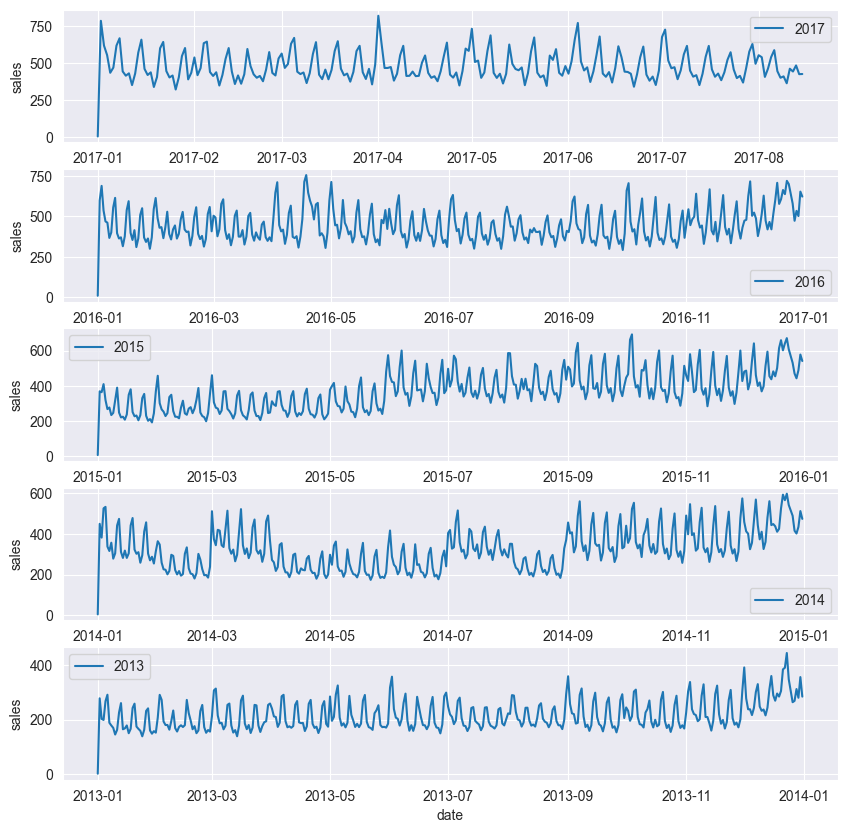

In [3]:
# plotting original data
avg = data_dict['avg'].copy()
x= avg['sales'].copy()


fig, ax = plt.subplots(5,1, figsize=(10,10))
## lets look at each year
for year in range(2013, 2018):
    year_data = data_dict['avg'][data_dict['avg'].index.year== year]
    x = year_data['sales'].copy()
    sns.lineplot(x, label=year, ax=ax[2017-year])

## We see alot of periodicity (is this a word?) in the data

Above is too dense, lets just do one year by year for now

## Initilaizing data here

[Text(0.5, 0, 'data'), Text(0, 0.5, 'day before')]

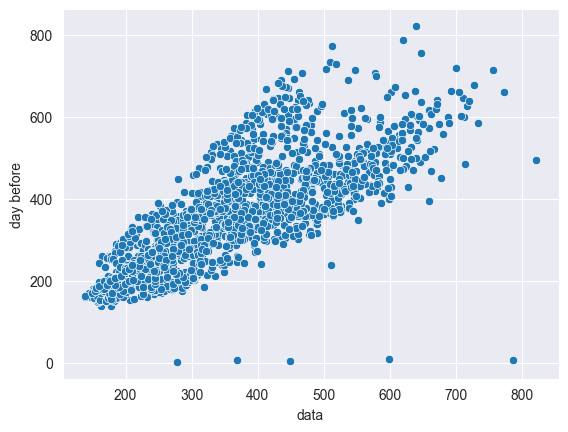

In [4]:
# what if we plot with the day respect to the day before?
data = data_dict['avg']
delayed = data.shift(1)

# drop each index for the first day of the year

data = data[data.index.dayofyear != 1]

ax = sns.scatterplot(x=data['sales'], y=delayed['sales'] )
ax.set(xlabel='data', ylabel='day before')

## disregarding the outlier seems like there is some correlation

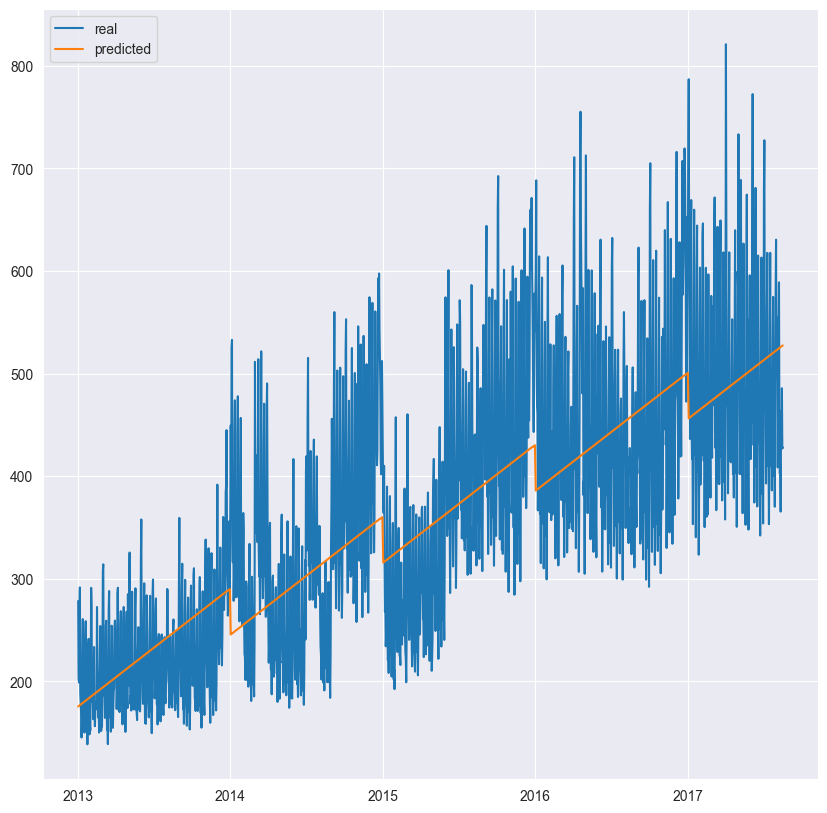

In [5]:
## fitting a linear regression
x = data.copy()

time_dummy = np.arange(len(x.index))
x['time'] = time_dummy


x = x.drop(['sales','onpromotion'], axis=1)
try:
    x = x.drop(['sales','onpromotion','id'], axis=1)
except:
    pass

y = data['sales'].copy()

model = LinearRegression()

model.fit(x,y)


y_pred = pd.Series(model.predict(x), index=x.index)

## plotting the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(y, label='real')
ax.plot(y_pred, label='predicted')
ax.legend()

Pretty terrible response, the model only fits with the timedummy (No surprieses here)  

0.6852640945295626


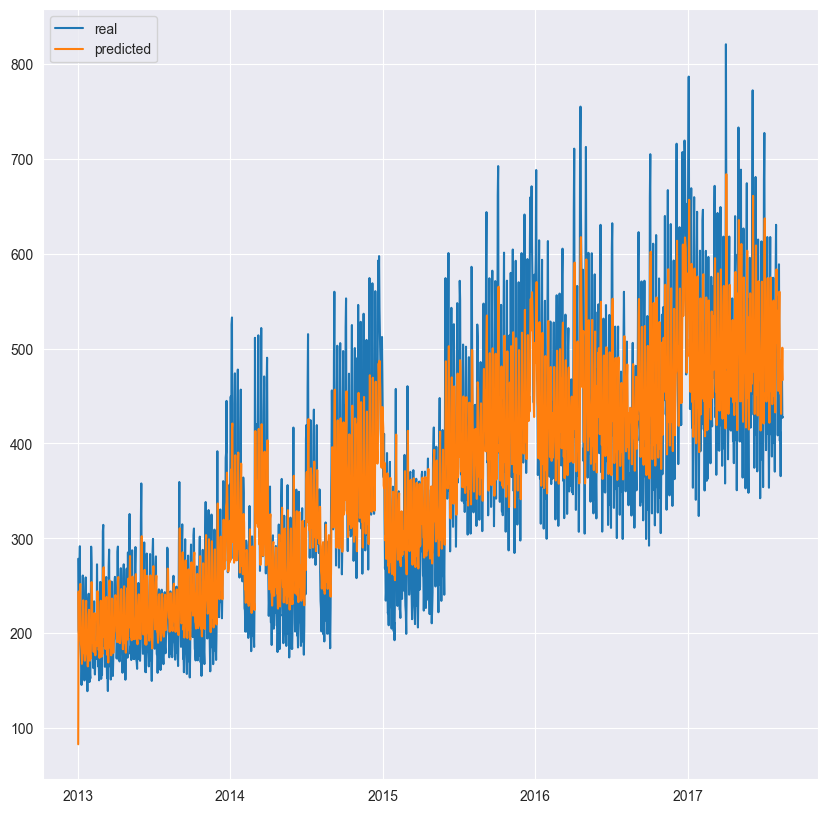

In [6]:
## what if we add the delay?
x = data.copy()
delayed = data.shift(1)
## make na to 0
delayed = delayed.fillna(0)
x['delayed'] = delayed['sales'] ## this will be the avg sales the day before

try:
    x = x.drop(['sales','onpromotion'], axis=1)
except:
    pass



y = data['sales'].copy()

model = LinearRegression()
model.fit(x,y)
y_pred = pd.Series(model.predict(x), index=x.index)


## plotting the results
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(y, label='real')
ax.plot(y_pred, label='predicted')
ax.legend()
acc = metrics.r2_score(y, y_pred)
print(acc)

Seems alot better, lets print for only 2017, to see how much better it actually performs

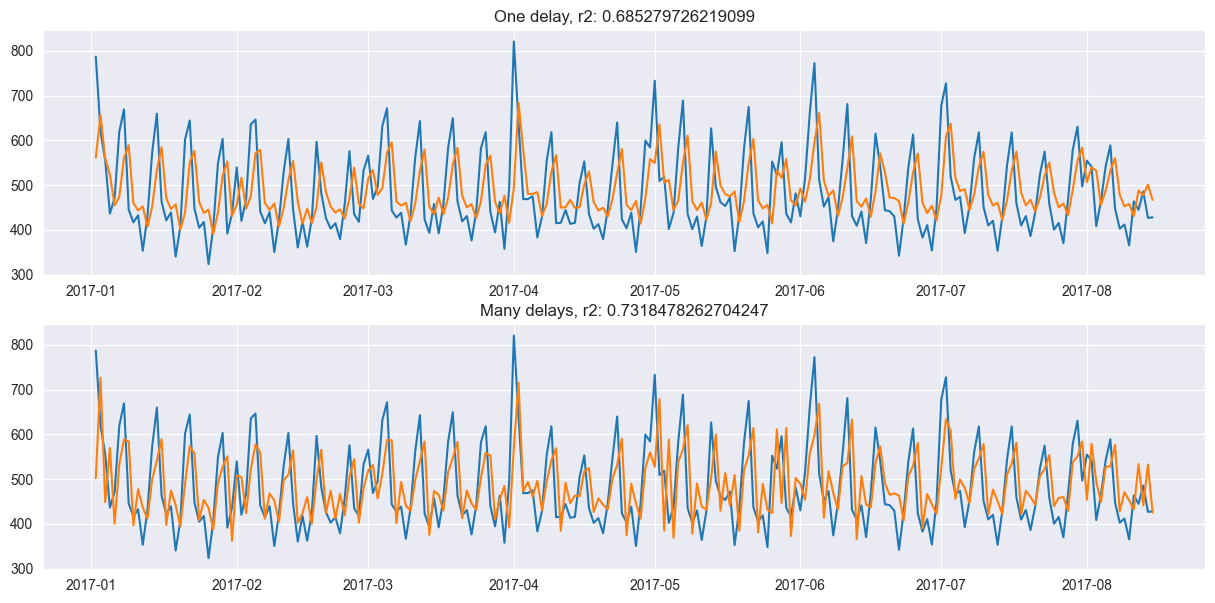

In [18]:
#Lets shorten the above code into one block and make two plots, one with many features and one with few
## lets do the same but lets also add more delay (5 days)
x = data.copy()
for i in range(1,6):
    delayed = data.shift(i)
    delayed = delayed.fillna(0)
    x['delayed'+str(i)] = delayed['sales']

try:
    x = x.drop(['sales','onpromotion','id'], axis=1)
except:
    pass

time_dummy = np.arange(len(x.index))
x['time'] = time_dummy


one_delayed = x[['delayed1','time']].copy()
many_delayed = x.copy()

model_one = LinearRegression() 
model_many = LinearRegression()

model_one.fit(one_delayed,y)
model_many.fit(many_delayed,y)

y_pred_one = pd.Series(model_one.predict(one_delayed), index=one_delayed.index)
y_pred_many = pd.Series(model_many.predict(many_delayed), index=many_delayed.index)
y17 = y[y.index.year==2017]

one_r2 = metrics.r2_score(y, y_pred_one)
many_r2 = metrics.r2_score(y, y_pred_many)

fig, ax = plt.subplots(2,1, figsize=(15,7))

ax[0].plot(y17, label='real')
ax[0].plot(y_pred_one[y_pred_one.index.year==2017], label='predicted')
ax[0].set_title('One delay, r2: '+str(one_r2))

ax[1].plot(y17, label='real')
ax[1].plot(y_pred_many[y_pred_many.index.year==2017], label='predicted')
ax[1].set_title('Many delays, r2: '+str(many_r2))

full_delayed = x.copy()

# Moving Average

                 id       sales  onpromotion
date                                        
2013-01-02   2672.5  278.390807          0.0
2013-01-03   4454.5  202.840197          0.0
2013-01-04   6236.5  198.911154          0.0
2013-01-05   8018.5  267.873244          0.0
2013-01-06   9800.5  291.636028          0.0
2013-01-07  11582.5  188.621100          0.0
2013-01-08  13364.5  178.646340          0.0
2013-01-09  15146.5  169.770375          0.0
2013-01-10  16928.5  145.332213          0.0
2013-01-11  18710.5  162.591294          0.0
2013-01-12  20492.5  226.295293          0.0
2013-01-13  22274.5  260.739926          0.0
2013-01-14  24056.5  164.617487          0.0
2013-01-15  25838.5  167.861700          0.0
2013-01-16  27620.5  178.646416          0.0
2013-01-17  29402.5  150.111401          0.0
2013-01-18  31184.5  166.178928          0.0
2013-01-19  32966.5  242.682296          0.0
2013-01-20  34748.5  258.749936          0.0
2013-01-21  36530.5  174.641563          0.0


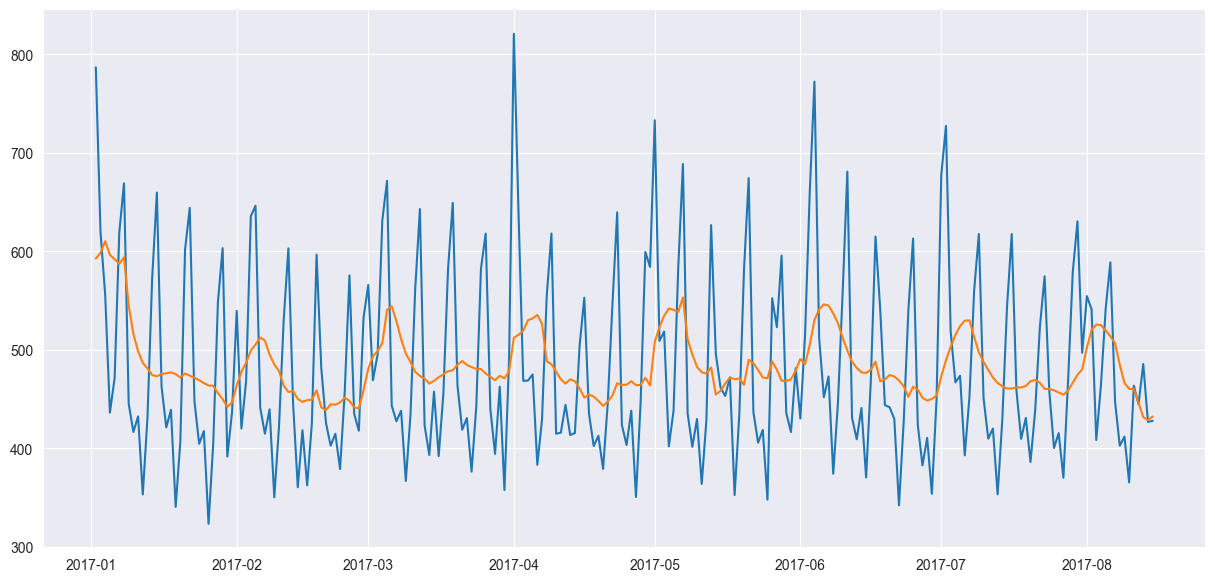

In [10]:
## We want to plot in the rolling average for 7 days

x = data.copy()
print(x.head(20))
average_7 = x['sales'].rolling(
    window=7, # window size
    min_periods= 1, ## Need this amount of data to calc the average
    center = False, ## is the weighted average in the center or the end (we want end) if not we would use future avg price to predict past
    win_type = None, ## Weighing points based on position  
).mean()

x['average'] = average_7

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(x['sales'][x.index.year == 2017], label='real')
ax.plot(x['average'][x.index.year == 2017], label='predicted')



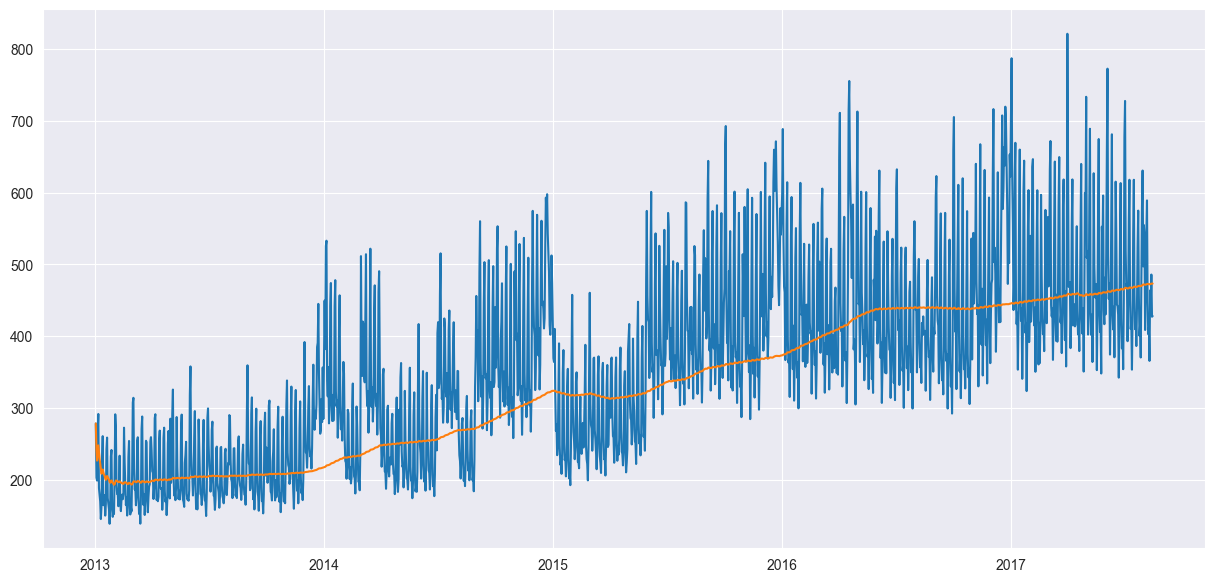

In [31]:
## We see that a small window size does not capture the trend of the data (we want more)
## lets try with a larger window size
x = data.copy()
average_365 = x['sales'].rolling(
    window=365, # window size
    min_periods= 1, ## Need this amount of data to calc the average
    center = False, ## is the weighted average in the center or the end (we want end) if not we would use future avg price to predict past
    win_type = None, ## Weighing points based on position  
).mean()

x['average'] = average_365

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(x['sales'], label='real')
ax.plot(x['average'], label='predicted')

## also making a 30 day average for later use
x = data.copy()
average_30 = x['sales'].rolling(
    window=30, # window size
    min_periods= 1, ## Need this amount of data to calc the average
    center = False, ## is the weighted average in the center or the end (we want end) if not we would use future avg price to predict past
    win_type = None, ## Weighing points based on position  
).mean()


In [20]:
## lets fit some linear models
lin_model = []
y = data['sales'].copy()
averages_list = [average_7, average_30, average_365]
str_list = ['7 day average', '30 day average', '365 day average']
for i,average in enumerate(averages_list):
    x = full_delayed.copy()
    x['average'] = average
    lin_model.append(LinearRegression().fit(x,y))
    y_pred = pd.Series(lin_model[-1].predict(x), index=x.index)
    acc = metrics.r2_score(y, y_pred)
    print(f'score of {str_list[i]} is: {acc}')
    
    

score of 7 day average is: 0.9086691461082862
score of 30 day average is: 0.7568565197801425
score of 365 day average is: 0.7320857596957142


In [33]:
## One hot enocde the day of the week
x = data.copy()
x['day'] = x.index.dayofweek
x = pd.get_dummies(x, columns=['day'], dtype=int)
average_7 = x['sales'].rolling(
    window=7, # window size
    min_periods= 1, ## Need this amount of data to calc the average
    center = False, ## is the weighted average in the center or the end (we want end) if not we would use future avg price to predict past
    win_type = None, ## Weighing points based on position  
).mean()
x['average'] = average_7

model = LinearRegression()
model.fit(x,y)
y_pred = pd.Series(model.predict(x), index=x.index)
acc = metrics.r2_score(y, y_pred)
print(f'score of one hot encoded day of week is: {acc}')


score of one hot encoded day of week is: 1.0
